# load modules

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import os
import numpy as np
import random
import re
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import math
import torchvision
from IPython.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:70% !important; }</style>"))

from useful_functions_notebook_14to18 import *
from useful_functions_notebook_8to13 import variable_consistancy_check, mass_not_preserved_percentage_decrease, check_branch_length, analyze_data

# load test data

In [25]:
dataset = torch.load('data/dataset.pt')
dataset = dataset.permute(1, 0, 2, 3)

norm_dataset = torch.load("data/dataset_distlognorm_massnorm.pt")

fake_original = torch.load('data/fake_dataset.pt')

fake_data = torch.load("models/attempt1/generated_images.pt")

six_branches = torch.load('data/six_branch_norm.pt')
six_dataset = six_branches[:, :, :, :6]

fake_data.shape, six_dataset.shape, dataset.shape, fake_original.shape

(torch.Size([8161, 3, 29, 6]),
 torch.Size([8161, 3, 29, 6]),
 torch.Size([38348, 3, 29, 10]),
 torch.Size([38500, 3, 29, 10]))

# verify consistency

# full original dataset

In [3]:
consist_data, inconsistent_images = check_consistency(dataset)

Consistency:


Percentage of consistant images = 97.51% vs. 97.51% in training data

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 0.00%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  68.52%
inconsistency due to zgap in branch 35.15%
inconsistency due to last descendant dont exist 0.00%

Number of images with two or more inconsistencies = 35, which is  3.67%
That corresponds to 0.09% of all images


Of all images, 0.00% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 1.70% have gap between branches inconsistency
Of all images, 0.87% have gap within branch inconsistency
Of all images, 0.00% have last descendant inconsistency





In [5]:
avg_branch = check_branch_length(consist_data)

Complexity:
number of images with 1 branches is: 0
number of images with 2 branches is: 0
number of images with 3 branches is: 0
number of images with 4 branches is: 0
number of images with 5 branches is: 7575
number of images with 6 branches is: 8012
number of images with 7 branches is: 7138
number of images with 8 branches is: 5990
number of images with 9 branches is: 4757
number of images with 10 branches is: 3923

total images = 37395

average number of branches in an image = 7.11 vs. 7.12 in training data
Average branch length = 9.07 vs. 9.06 in training data
Average nonzero entries (progenitors) = 64.49 vs. 64.55 in training data





In [25]:
consist_data, inconsistent_images = check_consistency(inconsistent_images[:20], print_index = True)

inconsistent images:
 image index = 0, inconsistent because gaps between branches 2 and 4 in channel 0
 image index = 1, inconsistent because gaps between branches 3 and 5 in channel 0
 image index = 2, inconsistent because gaps between branches 4 and 6 in channel 0
 image index = 3, inconsistent because gaps between branches 2 and 4 in channel 0
 image index = 4, inconsistent because gaps between branches 3 and 5 in channel 0
 image index = 5, inconsistent because gaps in branch 0 at row 7
 image index = 6, inconsistent because gaps in branch 0 at row 7
 image index = 7, inconsistent because gaps between branches 8 and 10 in channel 0
 image index = 8, inconsistent because gaps in branch 0 at row 16
 image index = 9, inconsistent because gaps between branches 4 and 6 in channel 0
 image index = 10, inconsistent because gaps between branches 5 and 7 in channel 0
 image index = 11, inconsistent because gaps between branches 1 and 3 in channel 0
 image index = 11, inconsistent because ga

### 97.51% of original training data is consistant based on the criterias. Main reason for inconsistency is gap in a branch (main branch) or gaps between branches in the distance variable

# Fake generated images from paper 3

In [26]:
consist_data_fake_original, inconsistent_images_fake_original = check_consistency(fake_original)



Percentage of consistant images = 0.0%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 100.00%
inconsistency due to distance not zero in main branch =  100.00%
inconsistency due to gap between branches =  68.55%
inconsistency due to zgap in branch 99.89%
inconsistency due to last descendant dont exist 0.00%

Number of images with two or more inconsistencies = 38499, which is  100.00%
That corresponds to 100.00% of all images


Of all images, 100.00% have zero inconsistency
Of all images, 100.00% have distance main branch inconsistency
Of all images, 68.55% have gap between branches inconsistency
Of all images, 99.89% have gap within branch inconsistency
Of all images, 0.00% have last descendant inconsistency


### look at why the images are not consistent

In [27]:
consist_data_fake_original_test, inconsistent_images_fake_original_test = check_consistency(fake_original[:10], print_index = True)

inconsistent images:
 image index = 0, inconsistent because zero not same index: zero in 84.38% of same spots across channels
 image index = 0, inconsistent because dist in main branch is not zero: zero in 17.24% of distance main branch
 image index = 0, inconsistent because gaps in branch 9 at row 23
 image index = 1, inconsistent because zero not same index: zero in 89.54% of same spots across channels
 image index = 1, inconsistent because dist in main branch is not zero: zero in 31.03% of distance main branch
 image index = 1, inconsistent because gaps in branch 6 at row 17
 image index = 2, inconsistent because zero not same index: zero in 80.99% of same spots across channels
 image index = 2, inconsistent because dist in main branch is not zero: zero in 20.69% of distance main branch
 image index = 2, inconsistent because gaps between branches 8 and 10 in channel 1
 image index = 2, inconsistent because gaps in branch 2 at row 11
 image index = 3, inconsistent because zero not sa

### 0.0% of fake generated images from paper 3 is consistant based on the criterias.  Multiple reasons:
- not zero in same spots, ranging from only 74% zeros in same spot
- distance not zero in main branch, ranging from as low as only 7% of main branch being 0.0 in distance variable
- gap between branches
- gap in a branch

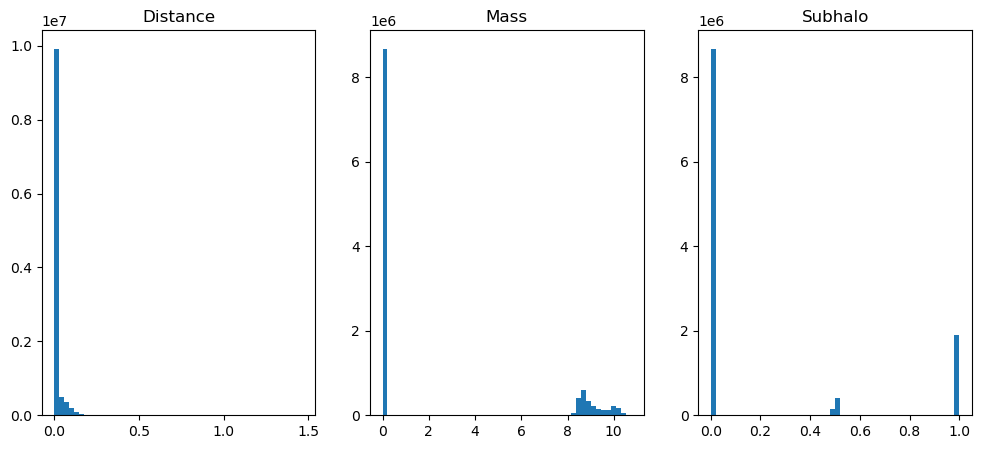

In [5]:

fake_original = torch.load('data/fake_dataset.pt')


dist = fake_original[:, 0]
mass = fake_original[:, 1]
subh = fake_original[:, 2]

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display the first image in the first subplot
axs[0].hist(dist.numpy().flatten(), bins = 50)
axs[0].set_title('Distance')

# Display the second image in the second subplot
axs[1].hist(mass.numpy().flatten(), bins = 50)
axs[1].set_title('Mass')

# Display the second image in the second subplot
axs[2].hist(subh.numpy().flatten(), bins = 50)
axs[2].set_title('Subhalo')

plt.show()

In [7]:
# dist
print("dist:")
lower_threshold = 0.35
upper_threshold = 0.6
count_between_thresholds = torch.sum((dist > lower_threshold) & (dist < upper_threshold)).item()
total_elements = dist.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

print("mass:")
lower_threshold = 0.01
upper_threshold = 0.8
count_between_thresholds = torch.sum((mass > lower_threshold) & (mass < upper_threshold)).item()
total_elements = mass.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

print("subh:")
lower_threshold = 0.01
upper_threshold = 0.46
count_between_thresholds = torch.sum((subh > lower_threshold) & (subh < upper_threshold)).item()
total_elements = subh.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")
lower_threshold = 0.55
upper_threshold = 0.97
count_between_thresholds = torch.sum((subh > lower_threshold) & (subh < upper_threshold)).item()
total_elements = subh.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")


dist:
Percentage of values between 0.35 and 0.6: 0.00%

mass:
Percentage of values between 0.01 and 0.8: 0.00%

subh:
Percentage of values between 0.01 and 0.46: 0.00%

Percentage of values between 0.55 and 0.97: 0.00%



In [5]:
fake_original = transform_diffusion_image(fake_original, d_thresh = 0.0, m_tresh = 0.5, s_low = 0.4, s_high = 0.77)

fake_original_con, fake_original_incon = check_consistency(fake_original)



Percentage of consistant images = 0.0%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 60.03%
inconsistency due to distance not zero in main branch =  100.00%
inconsistency due to gap between branches =  14.53%
inconsistency due to zgap in branch 46.87%
inconsistency due to last descendant dont exist 0.02%

Number of images with two or more inconsistencies = 23230, which is  60.34%
That corresponds to 60.34% of all images


Of all images, 60.03% have zero inconsistency
Of all images, 100.00% have distance main branch inconsistency
Of all images, 14.53% have gap between branches inconsistency
Of all images, 46.87% have gap within branch inconsistency
Of all images, 0.02% have last descendant inconsistency


In [6]:
nonzero_indices = torch.nonzero(dist.flatten())
nonzero_values = dist.flatten()[nonzero_indices]

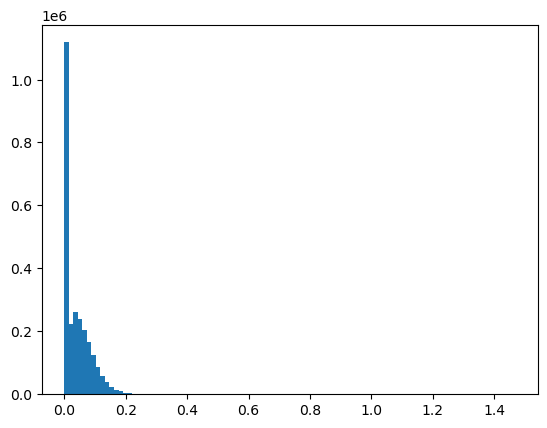

In [7]:
plt.hist(nonzero_values.numpy().flatten(), bins = 100)
plt.show()

In [8]:
nonzero_values.min()

tensor(1.0000e-06, dtype=torch.float64)

In [13]:
print("dist:")
lower_threshold = 1.0000e-06
upper_threshold = 0.01
count_between_thresholds = torch.sum((dist > lower_threshold) & (dist < upper_threshold)).item()
total_elements = dist.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

dist:
Percentage of values between 1e-06 and 0.01: 8.89%



In [14]:
fake_original = transform_diffusion_image(fake_original, d_thresh = 0.01, m_tresh = 0.5, s_low = 0.4, s_high = 0.77)

fake_original_con, fake_original_incon = check_consistency(fake_original)



Percentage of consistant images = 81.69%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 0.77%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  84.57%
inconsistency due to zgap in branch 19.89%
inconsistency due to last descendant dont exist 0.09%

Number of images with two or more inconsistencies = 368, which is  5.22%
That corresponds to 0.96% of all images


Of all images, 0.14% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 15.48% have gap between branches inconsistency
Of all images, 3.64% have gap within branch inconsistency
Of all images, 0.02% have last descendant inconsistency


In [20]:
d_thresh = [0.00007,0.00008,0.00009, 0.0001, 0.000125, 0.00015]
for d in d_thresh:
    fake_original = torch.load('data/fake_dataset.pt')
    fake_original[:, 0, :, 0] = 0.0
    fake_original = transform_diffusion_image(fake_original, d_thresh = d, m_tresh = 0.5, s_low = 0.4, s_high = 0.77)
    fake_original_con, fake_original_incon = check_consistency(fake_original)



Percentage of consistant images = 97.71%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 58.34%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  1.25%
inconsistency due to zgap in branch 79.00%
inconsistency due to last descendant dont exist 0.68%

Number of images with two or more inconsistencies = 342, which is  38.82%
That corresponds to 0.89% of all images


Of all images, 1.34% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 0.03% have gap between branches inconsistency
Of all images, 1.81% have gap within branch inconsistency
Of all images, 0.02% have last descendant inconsistency


Percentage of consistant images = 97.83%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 54.61%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  1.32%
inconsistency due to zgap in branch 7

In [21]:
fake_original = torch.load('data/fake_dataset.pt')
fake_original[:, 0, :, 0] = 0.0
fake_original = transform_diffusion_image(fake_original, d_thresh = 0.000125, m_tresh = 0.5, s_low = 0.4, s_high = 0.77)
fake_original_con, fake_original_incon = check_consistency(fake_original)



Percentage of consistant images = 98.09%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 40.62%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  1.49%
inconsistency due to zgap in branch 82.88%
inconsistency due to last descendant dont exist 0.82%

Number of images with two or more inconsistencies = 186, which is  25.27%
That corresponds to 0.48% of all images


Of all images, 0.78% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 0.03% have gap between branches inconsistency
Of all images, 1.58% have gap within branch inconsistency
Of all images, 0.02% have last descendant inconsistency


In [22]:
avg_branch = check_branch_length(fake_original_con)

Complexity:
number of images with 1 branches is: 0
number of images with 2 branches is: 0
number of images with 3 branches is: 0
number of images with 4 branches is: 0
number of images with 5 branches is: 7701
number of images with 6 branches is: 8102
number of images with 7 branches is: 7231
number of images with 8 branches is: 6119
number of images with 9 branches is: 4742
number of images with 10 branches is: 3869

total images = 37764

average number of branches in an image = 7.10 vs. 7.12 in training data
Average branch length = 9.06 vs. 9.06 in training data
Average nonzero entries (progenitors) = 64.30 vs. 64.55 in training data





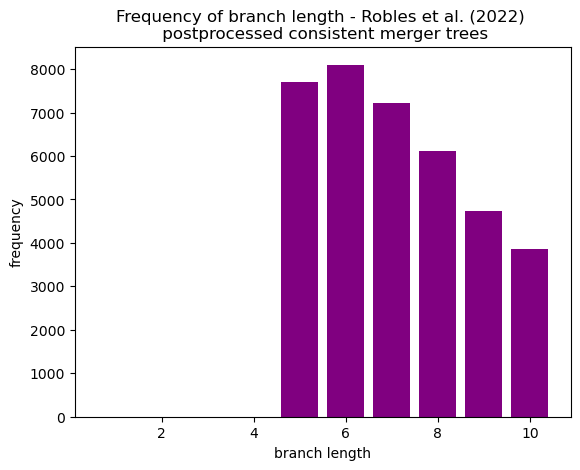

In [24]:
num_branches = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
length = [0, 0, 0, 0, 7701, 8102, 7231, 6119, 4742, 3869]

plt.bar(num_branches, length, color = "purple")

# Add title and labels
plt.title('Frequency of branch length - Robles et al. (2022) \n postprocessed consistent merger trees')
plt.xlabel('branch length')
plt.ylabel('frequency')

# Show the plot
plt.show()

In [31]:
dim = 1
skrrrt = torch.load('data/fake_dataset.pt')
ks_2samp(fake_original_con[:, dim].flatten(), dataset[:, dim].flatten())

KstestResult(statistic=0.0132081118045424, pvalue=0.0, statistic_location=8.542852, statistic_sign=-1)

Real images:


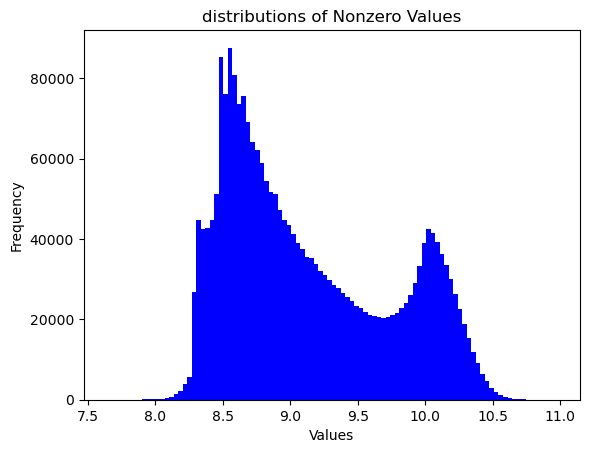

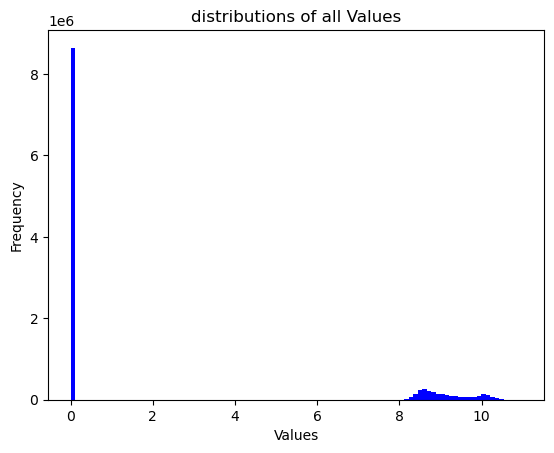

number of nonzero values = 2475374
Generated images:


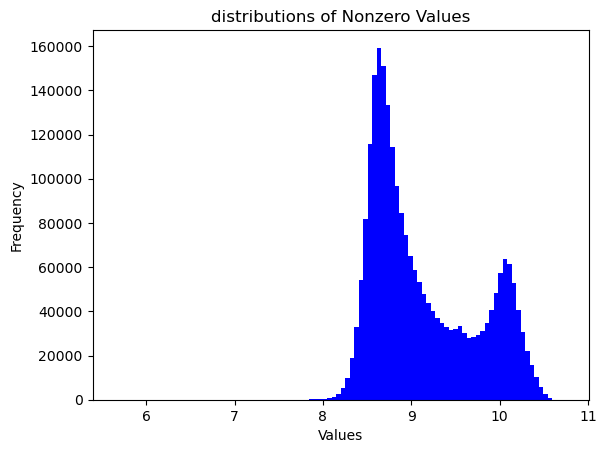

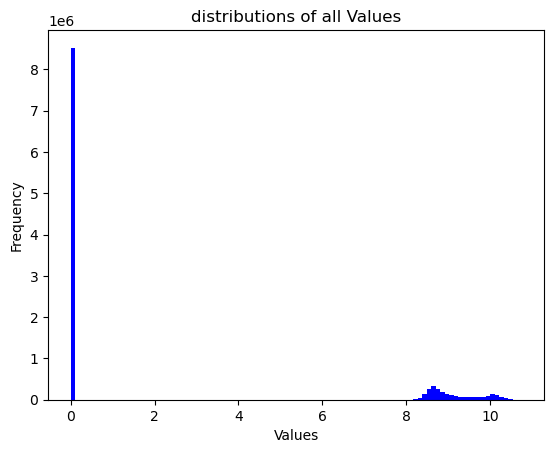

number of nonzero values = 2428337


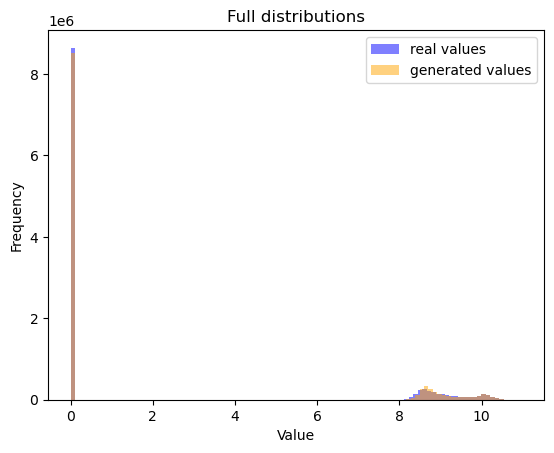

Full distribution:
KS Statistic: 0.0132081118045424
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0006:
The distributions are significantly different (reject H0), KS statistic 0.0132 > 0.0006


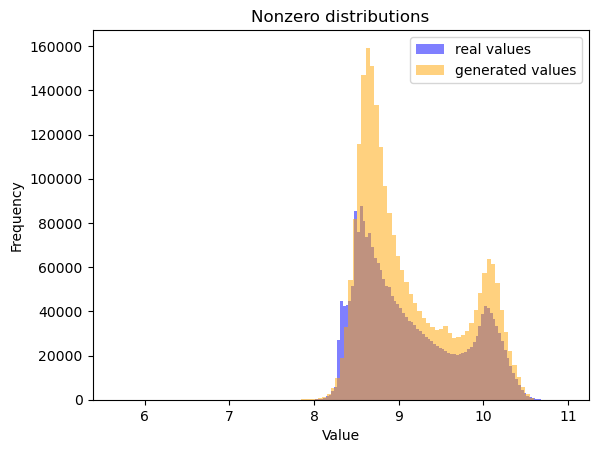

Nonzero distribution:
KS Statistic: 0.06271767705344444
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0012:
The distributions are significantly different (reject H0), KS statistic 0.0627 > 0.0012


(0.0132081118045424, 0.06271767705344444)

In [39]:
original = torch.load('data/dataset.pt')
original = original.permute(1, 0, 2, 3)
ks_test(original, fake_original_con, dim = 1)

MASS:
monotonicity threshold = -1e-06% change
number of occurences where mass is not preserved = 761053
perc of occurences where mass is not preserved = 31.83% vs. 25.77% in training data




monotonicity threshold = -0.01% change
number of occurences where mass is not preserved = 306170
perc of occurences where mass is not preserved = 12.80% vs. 11.12% in training data




monotonicity threshold = -0.05% change
number of occurences where mass is not preserved = 24497
perc of occurences where mass is not preserved = 1.02% vs. 1.71% in training data




monotonicity threshold = -0.1% change
number of occurences where mass is not preserved = 2817
perc of occurences where mass is not preserved = 0.12% vs. 0.32% in training data






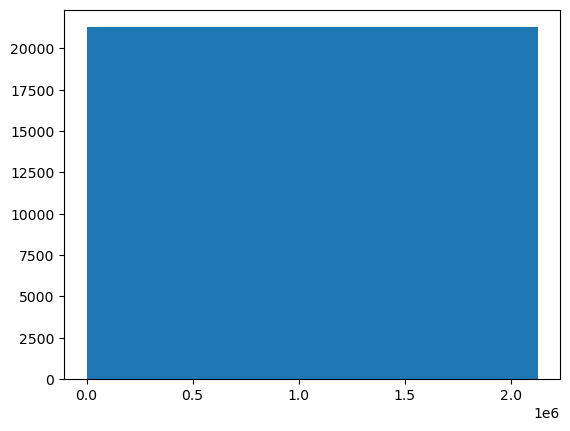

min mass change = 0.00% vs. -22.42% in training data
max mass change = 212702700.00% vs. 28.61% in training data
average mass change = 106351360.00% vs. 00.29% in training data



DISTANCE:


/Users/corneliusbencsik/Documents/master/notebooks/useful_functions_notebook_8to13.py:574: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"average mass change = {100 * torch.tensor(j, dtype = torch.float32).mean():.2f}% vs. 00.29% in training data", flush=True)


total distance progentors = 1511706 
number of occurences where distance increase (not preserved) = 797195
perc of occurences where mass increase (not preserved) = 52.73% vs. 49.67% in training data


total branches where the last halo distance to main branche is not the lowest in the branch is =  65969
percentage of all branches where the last halo distance to main branch is not the lowest in the branch is = 19.41% vs. 17.88% in training data


jumps greater than 20.0% (negative or positive) = 28.50% of all jumps vs. 4.76% in training data


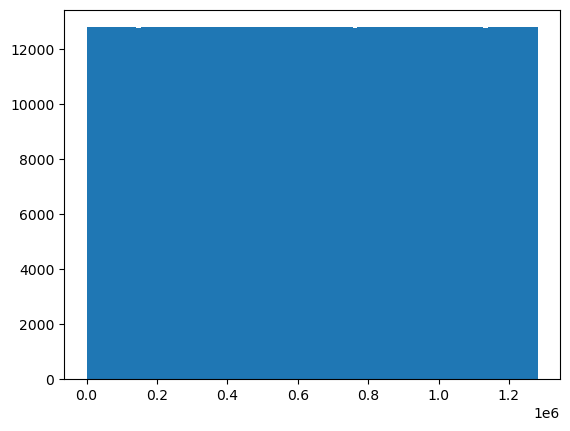

min jump = 0.00 vs. -80.70% in training data
max jump = 128141500.00 vs. 509.33% in training data
average jump = 64070648.00 vs. -2.60% in training data



SUBHALO:


/Users/corneliusbencsik/Documents/master/notebooks/useful_functions_notebook_8to13.py:591: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"average jump = {100 * torch.tensor(j, dtype = torch.float32).mean():.2f} vs. -2.60% in training data", flush=True)


perc of branches where last progenitor type is not subhalo = 14.46% vs 14.52% in training data




In [32]:
variable_consistancy_check(fake_original_con)

# six branches dataset

In [28]:
consist_data_six, inconsistent_images_six = check_consistency(six_dataset)



Percentage of consistant images = 98.17%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 0.00%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  47.65%
inconsistency due to zgap in branch 53.02%
inconsistency due to last descendant dont exist 0.00%

Number of images with two or more inconsistencies = 1, which is  0.67%
That corresponds to 0.01% of all images


Of all images, 0.00% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 0.87% have gap between branches inconsistency
Of all images, 0.97% have gap within branch inconsistency
Of all images, 0.00% have last descendant inconsistency


In [29]:
consist_data_six_test, inconsistent_images_six_test = check_consistency(inconsistent_images_six[:10], print_index = True)

inconsistent images:
 image index = 0, inconsistent because gaps between branches 4 and 6 in channel 0
 image index = 1, inconsistent because gaps between branches 3 and 5 in channel 0
 image index = 2, inconsistent because gaps between branches 2 and 4 in channel 0
 image index = 3, inconsistent because gaps between branches 3 and 5 in channel 0
 image index = 3, inconsistent because gaps in branch 0 at row 10
 image index = 4, inconsistent because gaps between branches 3 and 5 in channel 0
 image index = 5, inconsistent because gaps between branches 3 and 5 in channel 0
 image index = 6, inconsistent because gaps in branch 0 at row 6
 image index = 7, inconsistent because gaps in branch 0 at row 13
 image index = 8, inconsistent because gaps between branches 3 and 5 in channel 0
 image index = 9, inconsistent because gaps in branch 0 at row 16


Percentage of consistant images = 0.0%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 0.00%
inconsistency due to dist

Complexity:
number of images with 1 branches is: 0
number of images with 2 branches is: 0
number of images with 3 branches is: 0
number of images with 4 branches is: 0
number of images with 5 branches is: 0
number of images with 6 branches is: 8161
number of images with 7 branches is: 0
number of images with 8 branches is: 0
number of images with 9 branches is: 0
number of images with 10 branches is: 0

total images = 8161

average number of branches in an image = 6.00 vs. 7.12 in training data
Average branch length = 9.56 vs. 9.06 in training data
Average nonzero entries (progenitors) = 57.37 vs. 64.55 in training data



MASS:
monotonicity threshold = -1e-06% change
number of occurences where mass is not preserved = 89776
perc of occurences where mass is not preserved = 22.67% vs. 25.77% in training data




monotonicity threshold = -0.01% change
number of occurences where mass is not preserved = 36826
perc of occurences where mass is not preserved = 9.30% vs. 11.12% in training data

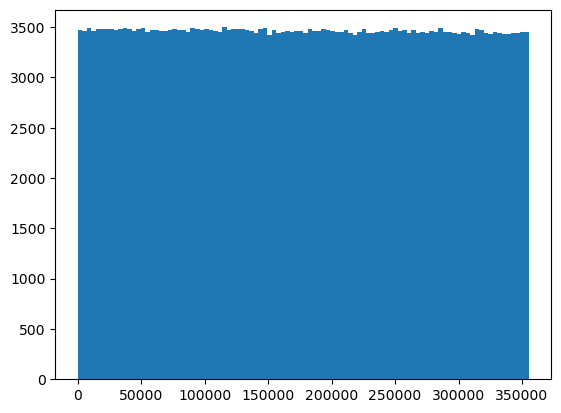

min mass change = 0.00% vs. -22.42% in training data
max mass change = 35529200.00% vs. 28.61% in training data
average mass change = 17736562.00% vs. 00.29% in training data



DISTANCE:


/Users/corneliusbencsik/Documents/master/notebooks/useful_functions_notebook_8to13.py:574: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"average mass change = {100 * torch.tensor(j, dtype = torch.float32).mean():.2f}% vs. 00.29% in training data", flush=True)


total distance progentors = 266699 
number of occurences where distance increase (not preserved) = 133606
perc of occurences where mass increase (not preserved) = 50.10% vs. 49.67% in training data


total branches where the last halo distance to main branche is not the lowest in the branch is =  10151
percentage of all branches where the last halo distance to main branch is not the lowest in the branch is = 24.88% vs. 17.88% in training data


jumps greater than 20.0% (negative or positive) = 4.62% of all jumps vs. 4.76% in training data


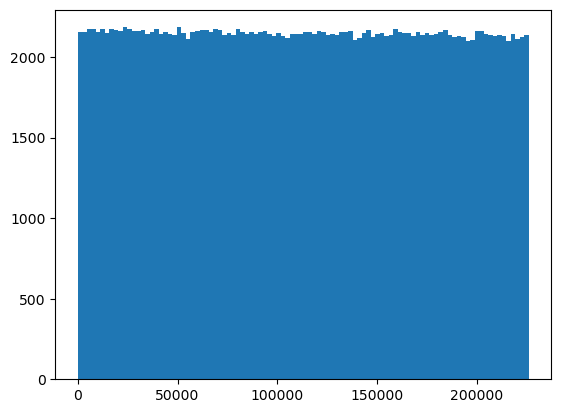

min jump = 0.00 vs. -80.70% in training data
max jump = 22598800.00 vs. 509.33% in training data
average jump = 11269309.00 vs. -2.60% in training data



SUBHALO:


/Users/corneliusbencsik/Documents/master/notebooks/useful_functions_notebook_8to13.py:591: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"average jump = {100 * torch.tensor(j, dtype = torch.float32).mean():.2f} vs. -2.60% in training data", flush=True)


perc of branches where last progenitor type is not subhalo = 21.27% vs 14.52% in training data




In [4]:
check_branch_length(six_dataset)
variable_consistancy_check(six_dataset)

### 98.17% of original training data with six branchesis consistant based on the criterias. Main reason for inconsistency is gap in a branch (main branch) or gaps between branches in the distance variable

# generated images with 6 branches only

In [30]:
consist_data_fake, inconsistent_images_fake = check_consistency(fake_data)



Percentage of consistant images = 9.62%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 65.29%
inconsistency due to distance not zero in main branch =  54.98%
inconsistency due to gap between branches =  27.49%
inconsistency due to zgap in branch 56.64%
inconsistency due to last descendant dont exist 0.28%

Number of images with two or more inconsistencies = 5166, which is  70.04%
That corresponds to 63.30% of all images


Of all images, 59.01% have zero inconsistency
Of all images, 49.69% have distance main branch inconsistency
Of all images, 24.85% have gap between branches inconsistency
Of all images, 51.19% have gap within branch inconsistency
Of all images, 0.26% have last descendant inconsistency


In [21]:
torch.save(consist_data_fake, "models/attempt1/consistent_generated_data.pt")
print("saved!!")

saved!!


In [31]:
consist_data_fake_fake, inconsistent_images_fake_fake = check_consistency(inconsistent_images_fake[:10], print_index = True)

inconsistent images:
 image index = 0, inconsistent because zero not same index: zero in 99.09% of same spots across channels
 image index = 0, inconsistent because gaps in branch 4 at row 15
 image index = 1, inconsistent because dist in main branch is not zero: zero in 79.31% of distance main branch
 image index = 1, inconsistent because gaps between branches 1 and 3 in channel 0
 image index = 1, inconsistent because gaps in branch 3 at row 13
 image index = 2, inconsistent because dist in main branch is not zero: zero in 86.21% of distance main branch
 image index = 2, inconsistent because gaps in branch 0 at row 18
 image index = 3, inconsistent because zero not same index: zero in 98.32% of same spots across channels
 image index = 3, inconsistent because dist in main branch is not zero: zero in 96.55% of distance main branch
 image index = 3, inconsistent because gaps in branch 1 at row 25
 image index = 4, inconsistent because zero not same index: zero in 99.19% of same spots a

### 9.62% of generated data with six branchesis consistant based on the criterias. Multiple reasons for inconsistency:
- not zero in same spots, ranging from 92 - 99% zeros in same spot
- distance not zero in main branch, ranging from 76 - 97%
- gap between branches
- gap in a branch

# inspecting consistent trees:

image 69:


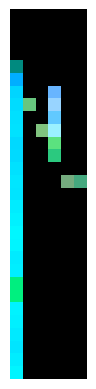

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 434:


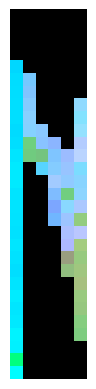

image 121:


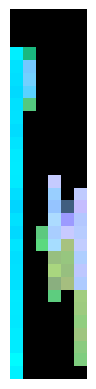

image 637:


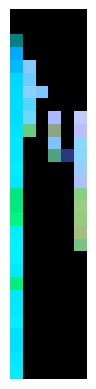

image 182:


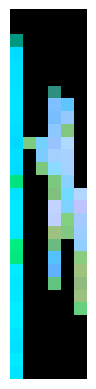

In [18]:
merger_trees_consistent_generated = plot_images(consist_data_fake, 5)

# inspecting inconsistent images

image 1367:


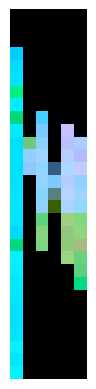

image 6386:


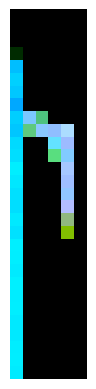

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 1413:


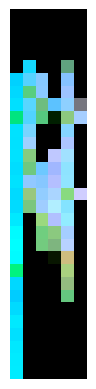

image 2435:


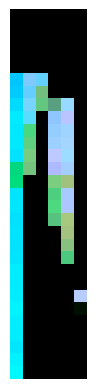

image 4052:


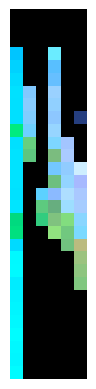

image 3819:


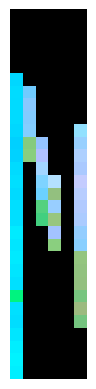

image 4129:


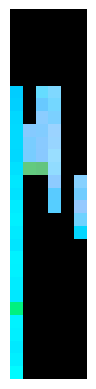

image 3923:


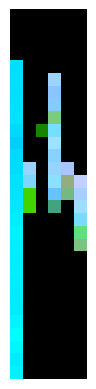

image 3086:


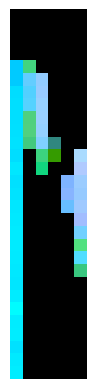

image 3513:


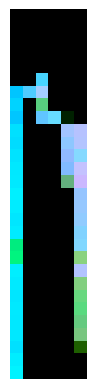

In [33]:
merger_trees_consistent_generated = plot_images(inconsistent_images_fake, 10)

# many of these the inconsistent merger trees look good, like image 1367 (0), 6386 (1), 2435 (3), 3923 (7), 3086 (8) and 3513 (9), so lets look more closely at why they are classified as inconsistent:

# also note that the inconsistent trees that are visibly inconsistent usually have some minor flaws 4052 (4), which has a barely visibly progenitor before the last branch, which creates the "gap in branch inonsistency". while 3819 (5) and 4129 (6) looks like create trees, but they have a hap between two branches

In [39]:
mt1367 = merger_trees_consistent_generated[0].unsqueeze(0)
mt6386 = merger_trees_consistent_generated[1].unsqueeze(0)
mt2435 = merger_trees_consistent_generated[3].unsqueeze(0)
mt3923 = merger_trees_consistent_generated[7].unsqueeze(0)
mt3086 = merger_trees_consistent_generated[8].unsqueeze(0)
mt3514 = merger_trees_consistent_generated[9].unsqueeze(0)

look_good_inconsistent_trees = torch.cat([mt1367, mt6386, mt2435, mt3923, mt3086, mt3514], dim = 0)
cons, incon = check_consistency(look_good_inconsistent_trees, print_index = True)

inconsistent images:
 image index = 0, inconsistent because zero not same index: zero in 99.07% of same spots across channels
 image index = 1, inconsistent because zero not same index: zero in 98.51% of same spots across channels
 image index = 2, inconsistent because zero not same index: zero in 99.13% of same spots across channels
 image index = 3, inconsistent because zero not same index: zero in 97.64% of same spots across channels
 image index = 3, inconsistent because gaps between branches 2 and 4 in channel 2
 image index = 4, inconsistent because zero not same index: zero in 99.17% of same spots across channels
 image index = 5, inconsistent because zero not same index: zero in 98.37% of same spots across channels


Percentage of consistant images = 0.0%


### all images are inconsistant because all channels dont have 0 in the same spots or because there is a gap in branch that we cannot see

In [40]:
def check_zeros_same_index_test(image):
    dist = image[:, 0]
    mass = image[:, 1]
    subh = image[:, 2]

    same_zero_indices = (dist == 0) & (mass == 0) & (subh == 0)
    
    print(same_zero_indices == (subh == 0))

    equal = same_zero_indices.sum() / (subh == 0).sum()
    
    return equal

In [43]:
check_zeros_same_index_test(mt3514)

tensor([[[ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True, False,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  

tensor(0.9837)

### two spots in the 5th branch where all channels are not 0

In [44]:
mt3514

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2799, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3094, 0.6434, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3473, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3784, 0.4057, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.6358, 0.7151],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.5565, 0.7053],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.5652, 0.5219],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.5088, 0.7695],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.3930, 0.7981],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5867],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5906],
          [0.0000, 0.0000, 0.0000, 0.000

### we see that the two places where the three channels are not all equal to 0 is because the subhalo value has 0.0 instead of a present progenitor category (last branch),  or because the mass predicts a small mass value instead of 0.0 (branch 5)

# check image mt3923 which have "gaps between branches 2 and 4 in channel 2"

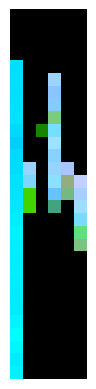

In [45]:
img = mt3923.squeeze(0)
img = img.permute(1, 2, 0).detach().numpy()
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

# initially, the image look good, and there look like there is no gaps between branches 2 and 4, since there is a progenitor there.

In [46]:
mt3923[:, 2]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 1.0000, 0.5000, 1.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 0.5000, 1.0000],
         [1.0000, 0.0000, 0.0000, 0.5000, 0.0000, 1.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000

### the issue seem to be a double error: first of all the subhalo value in branch 3 predict 0.0 instead of a nonzero value. secondly, This leads to a gap between branch 2 and 4 in the subhalo channel. this is a double error since one "off-value" gives two errors / inconsistencies in the same generated image.

# Even though only 9.62% of the generated images with six branches are 100% consistent in terms of structure, as we have seen, a lot of the images only have minor inconsistencies, like those seen in the generated images from paper 3. And compared to the generated images from paper 3, where 0 images (!!!) pass the consistency test, 9.62% seems like a decent result.

# check generated images from paper 3:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 23387:


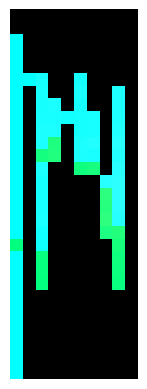

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 604:


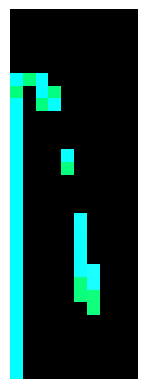

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 25552:


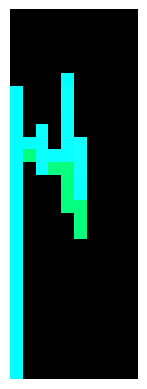

In [47]:
mergers = plot_images(fake_original, 3)

In [48]:
merger_tre = torch.stack(mergers)
cons, incon = check_consistency(merger_tre, print_index = True)

inconsistent images:
 image index = 0, inconsistent because zero not same index: zero in 83.90% of same spots across channels
 image index = 0, inconsistent because dist in main branch is not zero: zero in 6.90% of distance main branch
 image index = 0, inconsistent because gaps in branch 3 at row 14
 image index = 1, inconsistent because zero not same index: zero in 83.40% of same spots across channels
 image index = 1, inconsistent because dist in main branch is not zero: zero in 17.24% of distance main branch
 image index = 1, inconsistent because gaps between branches 8 and 10 in channel 1
 image index = 1, inconsistent because gaps in branch 1 at row 29
 image index = 2, inconsistent because zero not same index: zero in 91.67% of same spots across channels
 image index = 2, inconsistent because dist in main branch is not zero: zero in 20.69% of distance main branch
 image index = 2, inconsistent because gaps between branches 8 and 10 in channel 1
 image index = 2, inconsistent bec

# image 25552 with 4 inconsistencies:

In [65]:
merger_tre[2, 1, :, 2:3], merger_tre[2, 1, :, 7:]

(tensor([[0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [2.0000e-06],
         [2.0000e-06],
         [0.0000e+00],
         [8.6068e+00],
         [8.7397e+00],
         [8.8739e+00],
         [8.8846e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00]], dtype=torch.float64),
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000

### gap in the mass channel (2) in branch 2 row 10, and there are some small mass values really close to zero in the last mass branch

# see if we the number of consistant generated trees increase drastically if forcing main branch dist to be 0

In [66]:
test = fake_data.clone()
test[:, 0, :, 0] = 0.0

In [67]:
consist_data_fake, inconsistent_images_fake = check_consistency(test)



Percentage of consistant images = 20.18%


## increase to from 9.62% to 20.18% by the simple trick

In [68]:
consist_data_fake_test, inconsistent_images_fake_test = check_consistency(inconsistent_images_fake[:10], True)

inconsistent images:
 image index = 0, inconsistent because zero not same index: zero in 99.09% of same spots across channels
 image index = 0, inconsistent because gaps in branch 4 at row 15
 image index = 1, inconsistent because gaps between branches 1 and 3 in channel 0
 image index = 1, inconsistent because gaps in branch 3 at row 13
 image index = 2, inconsistent because gaps in branch 4 at row 11
 image index = 3, inconsistent because zero not same index: zero in 98.32% of same spots across channels
 image index = 3, inconsistent because gaps in branch 1 at row 25
 image index = 4, inconsistent because zero not same index: zero in 99.19% of same spots across channels
 image index = 4, inconsistent because gaps in branch 5 at row 23
 image index = 5, inconsistent because zero not same index: zero in 99.00% of same spots across channels
 image index = 6, inconsistent because zero not same index: zero in 99.25% of same spots across channels
 image index = 7, inconsistent because zer

### for the fake original data, the trick doesnt affect the consistency rate of 0.0%

### generally, it seems like the zero in same index in all channel inconsistency got better, that there are much less instanses in the inconsistant images

Real images:


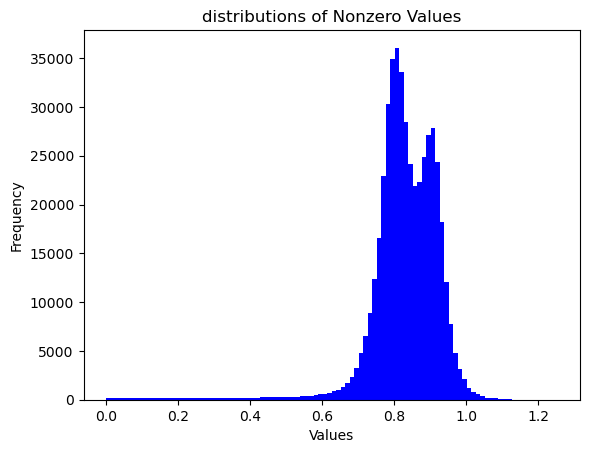

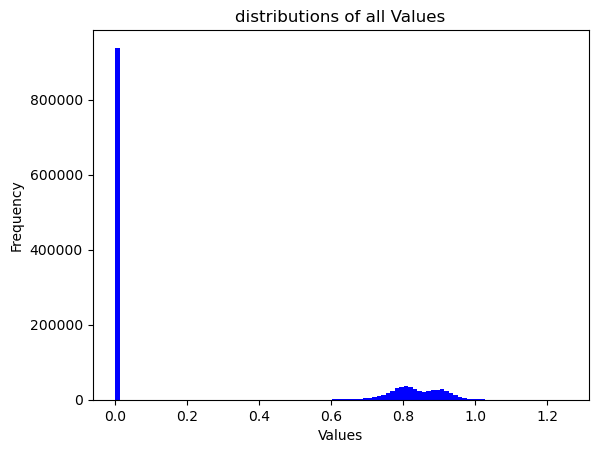

number of nonzero values = 482160
Generated images:


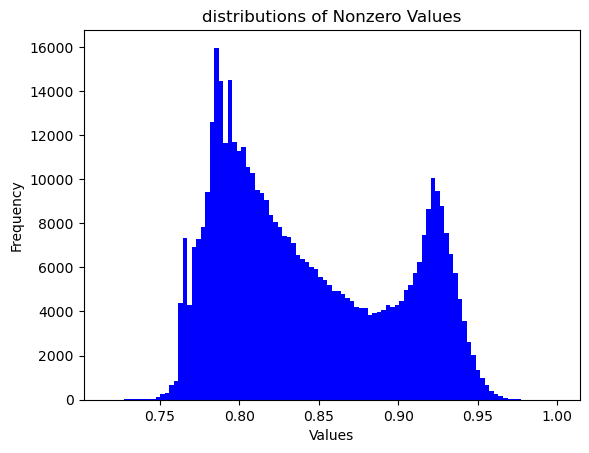

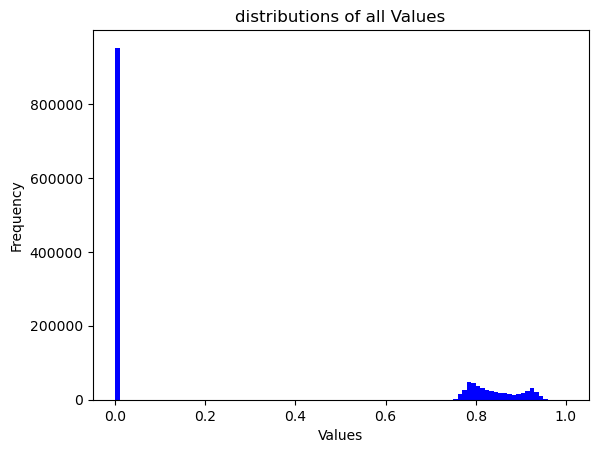

number of nonzero values = 468178


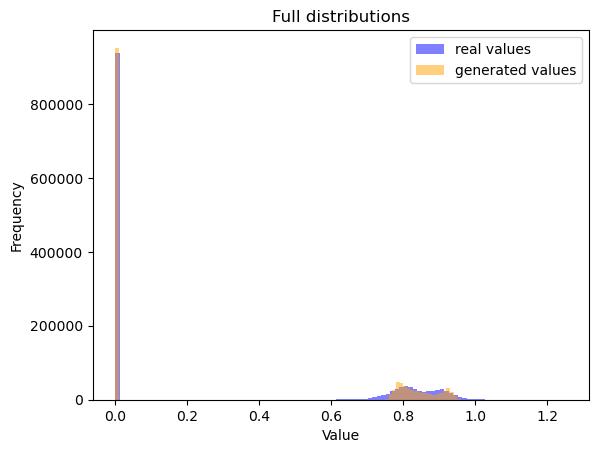

Full distribution:
KS Statistic: 0.03811934248535587
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0016:
The distributions are significantly different (reject H0), KS statistic 0.0381 > 0.0016


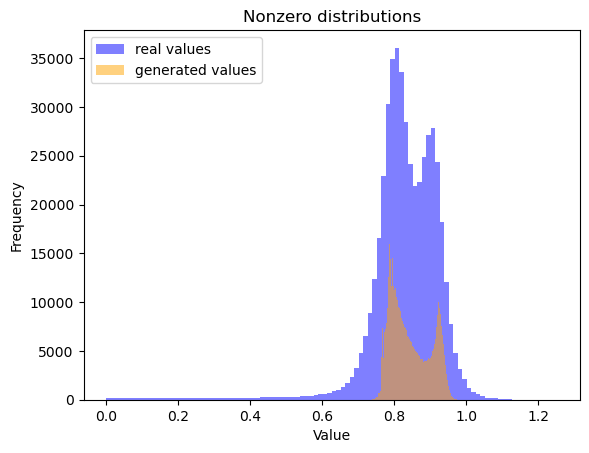

Nonzero distribution:
KS Statistic: 0.14108326168472823
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0028:
The distributions are significantly different (reject H0), KS statistic 0.1411 > 0.0028


(0.03811934248535587, 0.14108326168472823)

In [7]:
ks_test(fake_data, six_dataset, dim = 1)

Real images:


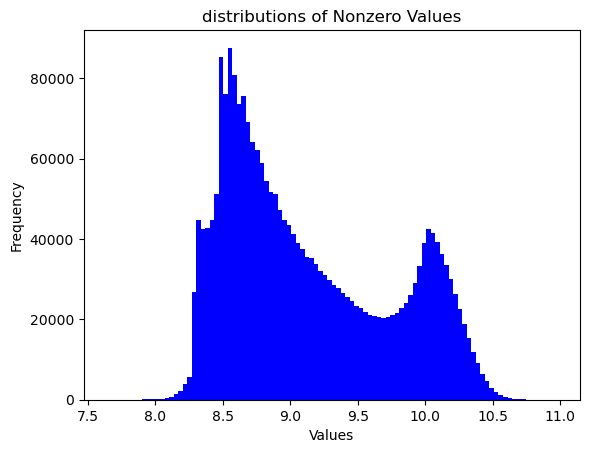

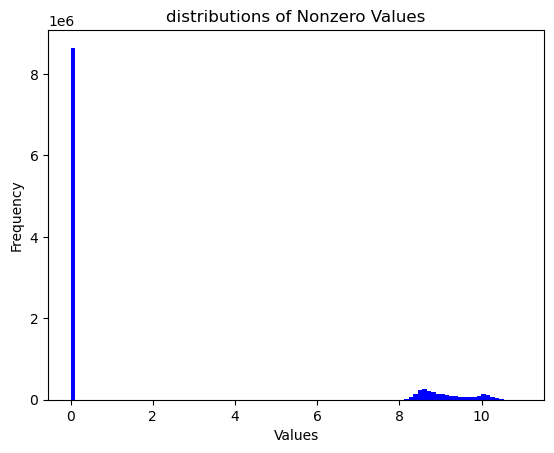

number of nonzero values = 2475374
Generated images:


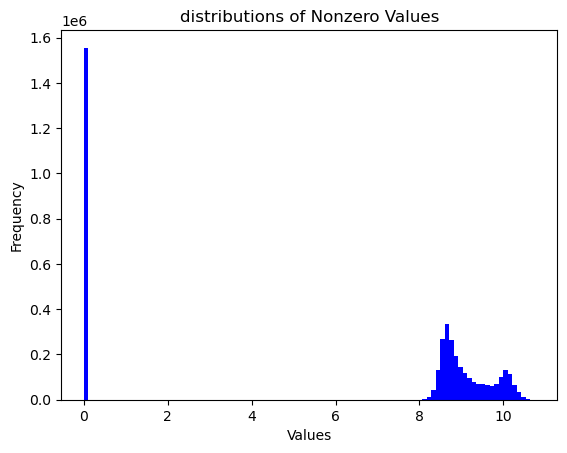

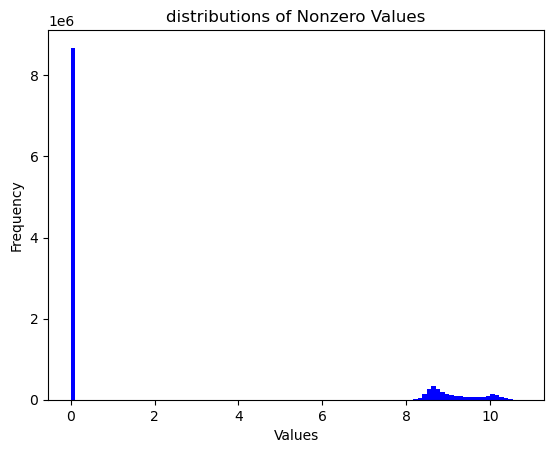

number of nonzero values = 4038570


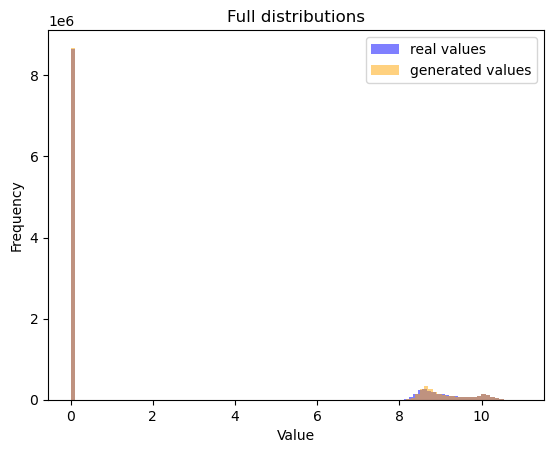

Full distribution:
KS Statistic: 0.13912981262738655
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0006:
The distributions are significantly different (reject H0), KS statistic 0.1391 > 0.0006


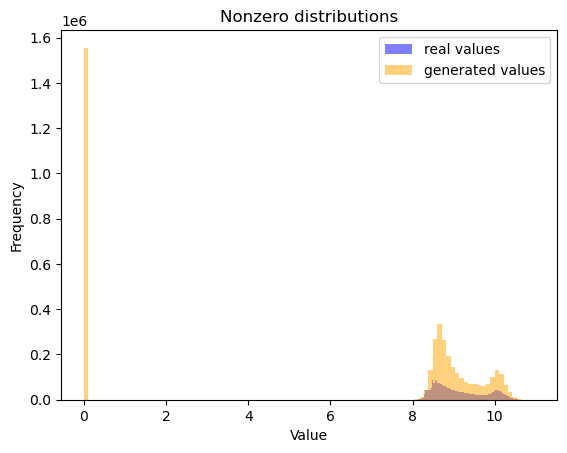

Nonzero distribution:
KS Statistic: 0.38531760321461994
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0011:
The distributions are significantly different (reject H0), KS statistic 0.3853 > 0.0011


(0.13912981262738655, 0.38531760321461994)

In [3]:
ks_test(dataset, fake_original, dim = 1)

# by removing the nonzero distance values in the main branch, the ks score drops from 0.016 to 0.011